# Global mean Sea Surface Temperatures

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

from calendar import monthrange

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pyproj

from globales import *
plt.rcParams['figure.figsize'] = (10, 4)

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=20, threads_per_worker=1)
client = Client(cluster)

/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43839 instead
  warnings.warn(


2025-05-08 10:37:31,891 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:46647 (pid=29282) exceeded 95% memory budget. Restarting...
2025-05-08 10:37:32,280 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:46647' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('rechunk-split-c388fb2f6cfda6fa9122fc1cd5f0fb81', 11), ('rechunk-merge-c388fb2f6cfda6fa9122fc1cd5f0fb81', 0, 0, 5), ('rechunk-split-c388fb2f6cfda6fa9122fc1cd5f0fb81', 12), ('rechunk-split-d4f35e72689a892808531fef2a3bc9fb', 58)} (stimulus_id='handle-worker-cleanup-1746700652.2802837')
2025-05-08 10:37:32,872 - distributed.nanny - WARNING - Restarting worker
2025-05-08 10:42:25,346 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:43009 (pid=29295) exceeded 95% memory budget. Restarting...
2025-05-08 10:42:25,712 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:43009' caused the cluster to lose already computed task(s), which

In [4]:
client.dashboard_link

'http://127.0.0.1:43839/status'

## Load data

In [5]:
base_file = GlobalSU['DatPath'] + '/Satelite/MUR/NC/'

In [6]:
year1= 2003
year2= 2024
files = []
for iy in range(year1,year2+1):
    for im in range(1,13):
        for id in range(1,monthrange(iy,im)[1]+1):
            files.append(base_file+"%04d%02d%02d090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"%(iy,im,id))

In [7]:
def drop_coords(ds):
    ds = ds.get(['analysed_sst'])
    return ds.reset_coords(drop=True)

DS = xr.open_mfdataset(files,combine='nested', concat_dim="time", parallel=True, combine_attrs= "drop", preprocess=drop_coords,autoclose = True, data_vars='minimal', coords="minimal", chunks={"time": 8036})

In [25]:
sst=DS.analysed_sst.sel(lon=slice(-19,-6),lat=slice(18,42))

In [26]:
sst

<xarray.DataArray 'analysed_sst' (time: 8036, lat: 2401, lon: 1301)> Size: 201GB
dask.array<getitem, shape=(8036, 2401, 1301), dtype=float64, chunksize=(1, 1023, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 64kB 2003-01-01T09:00:00 ... 2024-12-31T09...
  * lat      (lat) float32 10kB 18.0 18.01 18.02 18.03 ... 41.98 41.99 42.0
  * lon      (lon) float32 5kB -19.0 -18.99 -18.98 -18.97 ... -6.02 -6.01 -6.0

In [30]:
sst_re = sst.chunk({"time":8036})

In [31]:
sst_re

<xarray.DataArray 'analysed_sst' (time: 8036, lat: 2401, lon: 1301)> Size: 201GB
dask.array<rechunk-merge, shape=(8036, 2401, 1301), dtype=float64, chunksize=(8036, 1023, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 64kB 2003-01-01T09:00:00 ... 2024-12-31T09...
  * lat      (lat) float32 10kB 18.0 18.01 18.02 18.03 ... 41.98 41.99 42.0
  * lon      (lon) float32 5kB -19.0 -18.99 -18.98 -18.97 ... -6.02 -6.01 -6.0

In [33]:
z=sst_re.polyfit('time',deg=1).compute() 

/opt/conda/envs/ocean/lib/python3.11/site-packages/xarray/core/dataset.py:5195: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  stacked_var = exp_var.stack(**{new_dim: dims})
/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 21.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


MemoryError: Task ('rechunk-merge-bb968da8fe4ba784e3095644477bcbed', 0, 1, 1) has 27.77 GiB worth of input dependencies, but worker tcp://127.0.0.1:39819 has memory_limit set to 25.17 GiB.

In [17]:
z.polyfit_coefficients

<xarray.DataArray 'polyfit_coefficients' (degree: 2, lat: 1501, lon: 1001)> Size: 24MB
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [1.26097123e-18, 1.26585774e-18, 1.27041231e-18, ...,
                    nan,            nan,            nan],
        [1.25697635e-18, 1.26185387e-18, 1.26627351e-18, ...,
                    nan,            nan,            nan],
        [1.25312716e-18, 1.25766585e-18, 1.26208854e-18, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [2.91084091e+02, 2.91075735e+02, 2.91067823e+02, ...,
                    nan,            nan,            nan],
        [2.91084924e+02, 2.91076584e+02, 2.91068865e+02, ...,
                    nan,            nan,            nan],
        [2.91085583e+02, 2.91077736e+02, 2.91070035e+02, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * lat      (lat) float32 6kB 20.0 20.01 20.02 20.03 ... 34.97 34.98 34.99 35.0
  * lon      (lon) float32 4kB -15.0 -14.99 -14.98 -14.97 ... -5.02 -5.01 -5.0
  * degree   (degree) int64 16B 1 0

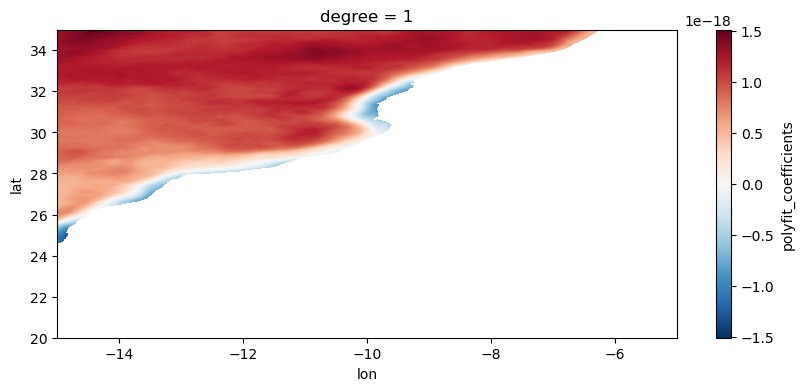

In [18]:
z.polyfit_coefficients[0,:,:].plot()